In [1]:
import os
import json
from itertools import chain
from collections import Counter, defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("default")


ROOT = "ee782_re_project"          


REFIND_PUB = os.path.join(ROOT, "data", "REFinD", "public_dat")


In [3]:
def load_refind_split(split_name):
    fname = f"{split_name}_refind_official.json"
    path = os.path.join(REFIND_PUB, fname)
    print(f"Loading {split_name} from {path}")
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
    print(f"  -> {len(data)} examples")
    return data

train_raw = load_refind_split("train")
dev_raw   = load_refind_split("dev")
test_raw  = load_refind_split("test")

len(train_raw), len(dev_raw), len(test_raw)


Loading train from ee782_re_project\data\REFinD\public_dat\train_refind_official.json
  -> 20070 examples
Loading dev from ee782_re_project\data\REFinD\public_dat\dev_refind_official.json
  -> 4306 examples
Loading test from ee782_re_project\data\REFinD\public_dat\test_refind_official.json
  -> 4300 examples


(20070, 4306, 4300)

In [5]:
all_rels = sorted({ex["relation"] for ex in chain(train_raw, dev_raw, test_raw)})
rel2id = {rel: i for i, rel in enumerate(all_rels)}
id2rel = {i: rel for rel, i in rel2id.items()}

def normalize_example(ex):
    tokens = ex["token"]
    e1 = {"start": ex["e1_start"], "end": ex["e1_end"], "type": ex["e1_type"]}
    e2 = {"start": ex["e2_start"], "end": ex["e2_end"], "type": ex["e2_type"]}
    rel_label = ex["relation"]
    return {
        "docid": ex["docid"],
        "tokens": tokens,
        "e1": e1,
        "e2": e2,
        "rel": rel_label,
        "rel_id": rel2id[rel_label],
        "rel_group": ex["rel_group"],
    }

train = [normalize_example(ex) for ex in train_raw]
dev   = [normalize_example(ex) for ex in dev_raw]
test  = [normalize_example(ex) for ex in test_raw]

len(train), len(dev), len(test), len(all_rels)


(20070, 4306, 4300, 22)

In [7]:
def basic_stats(split, name):
    n = len(split)
    rel_counts = Counter(ex["rel"] for ex in split)
    no_rel = rel_counts.get("no_relation", 0)
    print(f"=== {name} split ===")
    print(f"#examples: {n}")
    print(f"#relations (incl. no_relation): {len(rel_counts)}")
    print(f"no_relation: {no_rel} ({no_rel/n:.1%})")
    print()

    df = pd.DataFrame(
        [{"relation": r, "count": c, "freq": c/n}
         for r, c in rel_counts.most_common()]
    )
    return df

train_rel_df = basic_stats(train, "TRAIN")
dev_rel_df   = basic_stats(dev,   "DEV")
test_rel_df  = basic_stats(test,  "TEST")

train_rel_df.head(20)


=== TRAIN split ===
#examples: 20070
#relations (incl. no_relation): 22
no_relation: 9128 (45.5%)

=== DEV split ===
#examples: 4306
#relations (incl. no_relation): 22
no_relation: 1965 (45.6%)

=== TEST split ===
#examples: 4300
#relations (incl. no_relation): 22
no_relation: 1953 (45.4%)



,relation,count,freq
0,no_relation,9128,0.454808
1,pers:title:title,3126,0.155755
2,org:gpe:operations_in,2832,0.141106
3,pers:org:employee_of,1733,0.086348
4,org:org:agreement_with,653,0.032536
5,org:date:formed_on,448,0.022322
6,pers:org:member_of,441,0.021973
7,org:org:subsidiary_of,386,0.019233
8,org:org:shares_of,286,0.014250
9,org:money:revenue_of,217,0.010812


In [9]:
out_dir = os.path.join(ROOT, "analysis_refind")
os.makedirs(out_dir, exist_ok=True)
train_rel_df.to_csv(os.path.join(out_dir, "refind_train_relation_freq.csv"), index=False)


In [11]:
def lengths(split):
    return np.array([len(ex["tokens"]) for ex in split])

len_train = lengths(train)
len_dev   = lengths(dev)
len_test  = lengths(test)

def summarize(name, arr):
    print(f"=== {name} length stats ===")
    print(f"min   : {arr.min()}")
    print(f"max   : {arr.max()}")
    print(f"mean  : {arr.mean():.2f}")
    print(f"median: {np.median(arr):.2f}")
    print(f"p90   : {np.percentile(arr, 90):.2f}")
    print(f"p95   : {np.percentile(arr, 95):.2f}")
    print(f"p99   : {np.percentile(arr, 99):.2f}")
    print(f"% > 128: {(arr > 128).mean():.1%}")
    print(f"% > 256: {(arr > 256).mean():.1%}")
    print()

summarize("TRAIN", len_train)
summarize("DEV",   len_dev)
summarize("TEST",  len_test)


=== TRAIN length stats ===
min   : 6
max   : 1146
mean  : 53.40
median: 43.00
p90   : 90.00
p95   : 113.00
p99   : 304.62
% > 128: 3.8%
% > 256: 1.2%

=== DEV length stats ===
min   : 7
max   : 542
mean  : 51.27
median: 43.00
p90   : 91.50
p95   : 119.00
p99   : 174.00
% > 128: 3.4%
% > 256: 0.3%

=== TEST length stats ===
min   : 7
max   : 731
mean  : 54.85
median: 43.00
p90   : 96.00
p95   : 123.05
p99   : 241.01
% > 128: 4.4%
% > 256: 0.6%



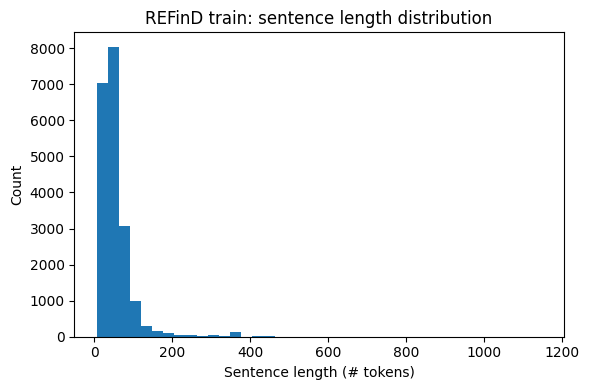

In [13]:
plt.figure(figsize=(6,4))
plt.hist(len_train, bins=40)
plt.xlabel("Sentence length (# tokens)")
plt.ylabel("Count")
plt.title("REFinD train: sentence length distribution")
plt.tight_layout()
plt.show()


In [15]:
def entity_distance(ex):
    s1, e1 = ex["e1"]["start"], ex["e1"]["end"]
    s2, e2 = ex["e2"]["start"], ex["e2"]["end"]
    # assume indices are token positions [start, end)
    left_end   = min(e1, e2)
    right_start = max(s1, s2)
    return max(0, right_start - left_end)

dist_train = np.array([entity_distance(ex) for ex in train])
dist_dev   = np.array([entity_distance(ex) for ex in dev])
dist_test  = np.array([entity_distance(ex) for ex in test])

def summarize_dist(name, arr):
    print(f"=== {name} entity distance (tokens between entities) ===")
    print(f"min   : {arr.min()}")
    print(f"max   : {arr.max()}")
    print(f"mean  : {arr.mean():.2f}")
    print(f"median: {np.median(arr):.2f}")
    print(f"p90   : {np.percentile(arr, 90):.2f}")
    print(f"p95   : {np.percentile(arr, 95):.2f}")
    print(f"% > 32: {(arr > 32).mean():.1%}")
    print(f"% > 64: {(arr > 64).mean():.1%}")
    print()

summarize_dist("TRAIN", dist_train)
summarize_dist("DEV",   dist_dev)
summarize_dist("TEST",  dist_test)


=== TRAIN entity distance (tokens between entities) ===
min   : 0
max   : 311
mean  : 12.37
median: 9.00
p90   : 28.00
p95   : 33.00
% > 32: 5.5%
% > 64: 0.2%

=== DEV entity distance (tokens between entities) ===
min   : 0
max   : 61
mean  : 12.38
median: 10.00
p90   : 27.00
p95   : 33.00
% > 32: 5.0%
% > 64: 0.0%

=== TEST entity distance (tokens between entities) ===
min   : 0
max   : 40
mean  : 12.84
median: 10.00
p90   : 29.00
p95   : 34.00
% > 32: 5.8%
% > 64: 0.0%



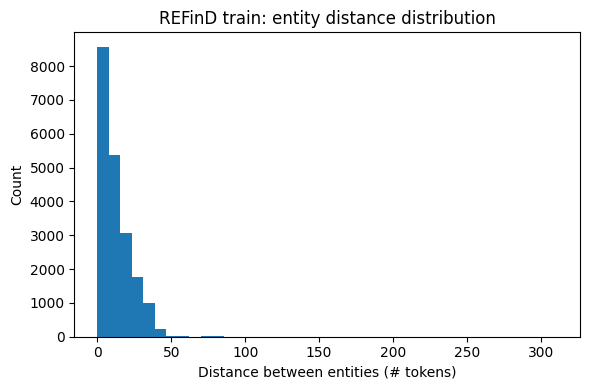

In [17]:
plt.figure(figsize=(6,4))
plt.hist(dist_train, bins=40)
plt.xlabel("Distance between entities (# tokens)")
plt.ylabel("Count")
plt.title("REFinD train: entity distance distribution")
plt.tight_layout()
plt.show()


In [19]:
import re
digit_re = re.compile(r"\d")

def count_numeric_tokens(ex):
    toks = ex["tokens"]
    num = sum(1 for t in toks if digit_re.search(t) is not None)
    return num, len(toks)

def numeric_stats(split):
    nums = []
    fracs = []
    for ex in split:
        n_num, n_tot = count_numeric_tokens(ex)
        nums.append(n_num)
        fracs.append(n_num / n_tot if n_tot > 0 else 0.0)
    return np.array(nums), np.array(fracs)

num_train, frac_train = numeric_stats(train)
num_dev,   frac_dev   = numeric_stats(dev)
num_test,  frac_test  = numeric_stats(test)

def summarize_numeric(name, nums, fracs):
    print(f"=== {name} numeric-token stats ===")
    print(f"mean #numeric tokens: {nums.mean():.2f}")
    print(f"median #: {np.median(nums):.2f}")
    print(f"mean fraction numeric: {fracs.mean():.3f}")
    print(f"% sentences with ≥1 numeric token: {(nums > 0).mean():.1%}")
    print()

summarize_numeric("TRAIN", num_train, frac_train)
summarize_numeric("DEV",   num_dev,   frac_dev)
summarize_numeric("TEST",  num_test,  frac_test)


=== TRAIN numeric-token stats ===
mean #numeric tokens: 2.19
median #: 2.00
mean fraction numeric: 0.045
% sentences with ≥1 numeric token: 64.9%

=== DEV numeric-token stats ===
mean #numeric tokens: 2.40
median #: 2.00
mean fraction numeric: 0.050
% sentences with ≥1 numeric token: 65.7%

=== TEST numeric-token stats ===
mean #numeric tokens: 2.54
median #: 2.00
mean fraction numeric: 0.048
% sentences with ≥1 numeric token: 69.8%



In [21]:
rel_numeric_counts = defaultdict(lambda: {"num_sent": 0, "num_with_digit": 0})

for split in (train, dev, test):
    for ex in split:
        rel = ex["rel"]
        n_num, _ = count_numeric_tokens(ex)
        rel_numeric_counts[rel]["num_sent"] += 1
        if n_num > 0:
            rel_numeric_counts[rel]["num_with_digit"] += 1

rows = []
for rel, stats in rel_numeric_counts.items():
    n = stats["num_sent"]
    k = stats["num_with_digit"]
    rows.append({
        "relation": rel,
        "#examples": n,
        "#with_numeric": k,
        "frac_with_numeric": k / n if n > 0 else 0.0,
    })

rel_numeric_df = pd.DataFrame(rows).sort_values("frac_with_numeric", ascending=False)
rel_numeric_df.head(20)


,relation,#examples,#with_numeric,frac_with_numeric
21,org:date:acquired_on,186,186,1.000000
20,org:date:formed_on,640,640,1.000000
19,org:money:profit_of,29,29,1.000000
18,org:money:cost_of,23,23,1.000000
17,org:money:loss_of,202,202,1.000000
16,org:money:revenue_of,311,311,1.000000
4,org:org:acquired_by,78,71,0.910256
3,org:org:shares_of,408,350,0.857843
1,org:org:agreement_with,935,766,0.819251
9,pers:org:employee_of,2479,1828,0.737394


In [23]:
rel_numeric_df.to_csv(os.path.join(out_dir, "refind_relation_numeric_density.csv"), index=False)


In [25]:
summary_rows = [
    {
        "split": "train",
        "n_examples": len(train),
        "mean_len": len_train.mean(),
        "p90_len": np.percentile(len_train, 90),
        "mean_dist": dist_train.mean(),
        "p90_dist": np.percentile(dist_train, 90),
        "frac_len>128": (len_train > 128).mean(),
        "frac_len>256": (len_train > 256).mean(),
        "frac_num>0":   (num_train > 0).mean(),
    },
    {
        "split": "dev",
        "n_examples": len(dev),
        "mean_len": len_dev.mean(),
        "p90_len": np.percentile(len_dev, 90),
        "mean_dist": dist_dev.mean(),
        "p90_dist": np.percentile(dist_dev, 90),
        "frac_len>128": (len_dev > 128).mean(),
        "frac_len>256": (len_dev > 256).mean(),
        "frac_num>0":   (num_dev > 0).mean(),
    },
    {
        "split": "test",
        "n_examples": len(test),
        "mean_len": len_test.mean(),
        "p90_len": np.percentile(len_test, 90),
        "mean_dist": dist_test.mean(),
        "p90_dist": np.percentile(dist_test, 90),
        "frac_len>128": (len_test > 128).mean(),
        "frac_len>256": (len_test > 256).mean(),
        "frac_num>0":   (num_test > 0).mean(),
    },
]

summary_df = pd.DataFrame(summary_rows)
summary_df


,split,n_examples,mean_len,p90_len,mean_dist,p90_dist,frac_len>128,frac_len>256,frac_num>0
0,train,20070,53.403538,90.0,12.369706,28.0,0.037818,0.012058,0.649427
1,dev,4306,51.274501,91.5,12.375523,27.0,0.034371,0.003019,0.657222
2,test,4300,54.853721,96.0,12.837674,29.0,0.044186,0.006279,0.698140
